# PW1 - Handwritten character recognition


In [162]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Arnaud COURNIL"
assert your_name

In [163]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [164]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [165]:
NUM_EPOCH = 10

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [ ]:
#root_dir = './data/MNIST/'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

In [167]:
print("Nb d'images dans train :",len(train_dataset),"; nb d'images dans test :",len(test_dataset))

Nb d'images dans train : 60000 ; nb d'images dans test : 10000


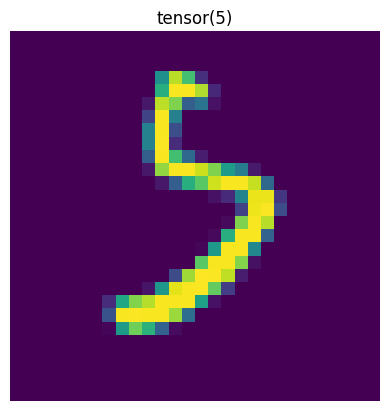

In [168]:
images, labels = list(train_loader)[0]

plt.imshow(images[0][0])
plt.title(labels[0])
plt.axis('off')
plt.show()

In [169]:
print("Dimension d'une image", (images[0][0].shape))

Dimension d'une image torch.Size([28, 28])


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_channels=1, output_dim=10):
        super().__init__()
        self.linear = nn.Linear(7 * 7 * input_channels, output_dim)

    def preprocess(self, x):
        x = nn.functional.avg_pool2d(x, kernel_size=4)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, x):
        x = self.preprocess(x)
        return self.linear(x)

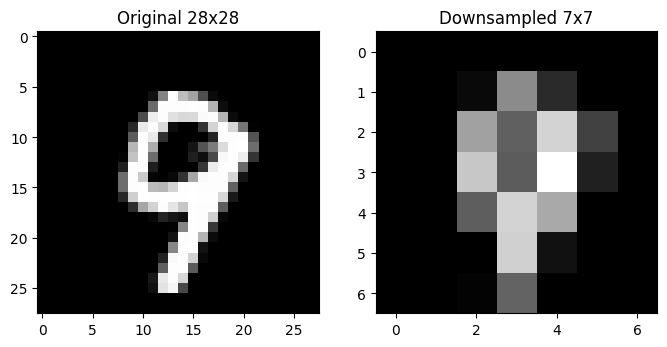

In [202]:
images, labels = list(train_loader)[0]
image, label = images[0], labels[0]

model = LinearModel()
downsampled = model.preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(image.squeeze().numpy(), cmap='gray')
axs[0].set_title("Original 28x28")

axs[1].imshow(downsampled.view(7, 7).detach().numpy(), cmap='gray')
axs[1].set_title("Downsampled 7x7")

plt.show()

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [171]:
criterion = nn.CrossEntropyLoss()

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [172]:
def train(model, epoch, train_loader, optimizer, device='cpu'):
    model.to(device)
    model.train()
    total_correct = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        preds = output.argmax(dim=1)
        total_correct += preds.eq(target).sum().item()
        total_samples += target.size(0)

    train_accuracy = total_correct / total_samples
    return optimizer, train_accuracy


def test(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            total_correct += pred.eq(target).sum().item()
            total_samples += target.size(0)

    accuracy = total_correct / total_samples
    return accuracy

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [173]:
model = LinearModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, train_loader, optimizer, device)
    test_acc = test(model, test_loader, device)
    print(f"Époque {epoch}: train acc = {train_acc:.4f}, test acc = {test_acc:.4f}")

Époque 0: train acc = 0.7610, test acc = 0.8379
Époque 1: train acc = 0.8427, test acc = 0.8577
Époque 2: train acc = 0.8524, test acc = 0.8668
Époque 3: train acc = 0.8571, test acc = 0.8702
Époque 4: train acc = 0.8604, test acc = 0.8715
Époque 5: train acc = 0.8630, test acc = 0.8726
Époque 6: train acc = 0.8651, test acc = 0.8757
Époque 7: train acc = 0.8667, test acc = 0.8769
Époque 8: train acc = 0.8678, test acc = 0.8784
Époque 9: train acc = 0.8689, test acc = 0.8777


## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [174]:
class MLP(nn.Module):
    def __init__(self, width, depth, input_dim = 28 * 28, output_dim = 10):
        super().__init__()
        layers = []

        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())

        for _ in range(depth - 2):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        if depth > 1:
            layers.append(nn.Linear(width, output_dim))
        else:
            layers[0] = nn.Linear(input_dim, output_dim)

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.preprocess(x)
        return self.net(x)
    
    def preprocess(self, x):
        return x.flatten(1)

In [175]:
model = MLP(width=100, depth=3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, train_loader, optimizer, device)
    test_acc = test(model, test_loader, device)
    print(f"Époque {epoch}: train acc = {train_acc:.4f}, test acc = {test_acc:.4f}")

Époque 0: train acc = 0.8480, test acc = 0.9243
Époque 1: train acc = 0.9354, test acc = 0.9457
Époque 2: train acc = 0.9513, test acc = 0.9398
Époque 3: train acc = 0.9615, test acc = 0.9601
Époque 4: train acc = 0.9683, test acc = 0.9660
Époque 5: train acc = 0.9725, test acc = 0.9691
Époque 6: train acc = 0.9760, test acc = 0.9670
Époque 7: train acc = 0.9795, test acc = 0.9673
Époque 8: train acc = 0.9820, test acc = 0.9715
Époque 9: train acc = 0.9839, test acc = 0.9743


# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [176]:
class ConvModel(nn.Module):
    def __init__(self, output_dim=10):
        super(ConvModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(8 * 13 * 13, output_dim)

    def forward(self, x):
        x = self.preprocess(x)
        x = self.conv(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def preprocess(self, x):
        return x

In [177]:
model = ConvModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, train_loader, optimizer, device)
    test_acc = test(model, test_loader, device)
    print(f"Époque {epoch}: train acc = {train_acc:.4f}, test acc = {test_acc:.4f}")

Époque 0: train acc = 0.8922, test acc = 0.9436
Époque 1: train acc = 0.9588, test acc = 0.9556
Époque 2: train acc = 0.9690, test acc = 0.9705
Époque 3: train acc = 0.9733, test acc = 0.9643
Époque 4: train acc = 0.9758, test acc = 0.9708
Époque 5: train acc = 0.9779, test acc = 0.9774
Époque 6: train acc = 0.9798, test acc = 0.9762
Époque 7: train acc = 0.9807, test acc = 0.9680
Époque 8: train acc = 0.9821, test acc = 0.9789
Époque 9: train acc = 0.9830, test acc = 0.9770


You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [ ]:
class DeepConvModel(nn.Module):
    def __init__(self, h=100, output_dim=10):
        super(DeepConvModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.flatten_dim = 8 * 13 * 13
        
        self.fc1 = nn.Linear(self.flatten_dim, h)
        self.fc2 = nn.Linear(h, h)
        self.fc3 = nn.Linear(h, output_dim)

    def forward(self, x):
        x = self.preprocess(x)
        x = self.conv(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def preprocess(self, x):
        return x

In [197]:
model = DeepConvModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, train_loader, optimizer, device)
    test_acc = test(model, test_loader, device)
    print(f"Époque {epoch}: train acc = {train_acc:.4f}, test acc = {test_acc:.4f}")

Époque 0: train acc = 0.8208, test acc = 0.9286
Époque 1: train acc = 0.9499, test acc = 0.9524
Époque 2: train acc = 0.9660, test acc = 0.9674
Époque 3: train acc = 0.9759, test acc = 0.9649
Époque 4: train acc = 0.9805, test acc = 0.9761
Époque 5: train acc = 0.9841, test acc = 0.9719
Époque 6: train acc = 0.9863, test acc = 0.9785
Époque 7: train acc = 0.9391, test acc = 0.9725
Époque 8: train acc = 0.9811, test acc = 0.9775
Époque 9: train acc = 0.9857, test acc = 0.9810


## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

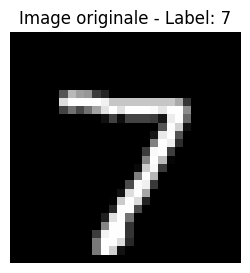

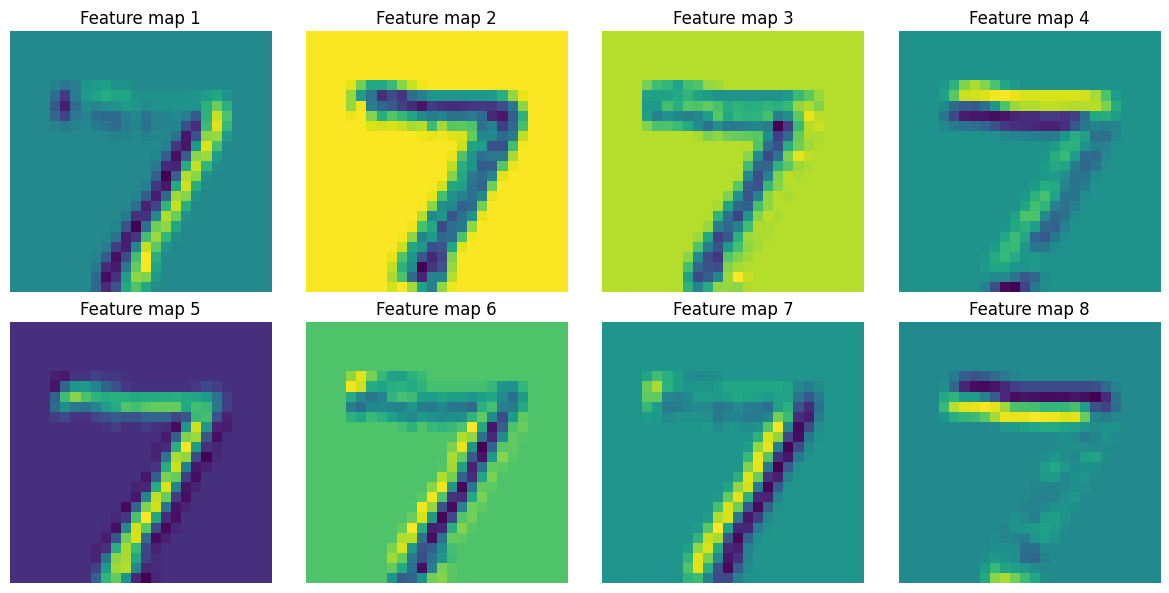

In [198]:
sample_img, sample_label = next(iter(test_loader))
sample_img = sample_img[0].unsqueeze(0).to(device) 

model.eval()

with torch.no_grad():
    x = model.preprocess(sample_img)
    conv_out = model.conv(x)

plt.figure(figsize=(3, 3))
plt.title(f"Image originale - Label: {sample_label[0].item()}")
plt.imshow(sample_img.squeeze().cpu(), cmap="gray")
plt.axis("off")
plt.show()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(conv_out[0, i].cpu(), cmap="viridis")
    ax.set_title(f"Feature map {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [ ]:
class ResidualBlock(torch.nn.Module):
    def init(self, d, h):
        super(ResidualBlock, self).init()
        self.linear1 = torch.nn.Linear(d, h)
        self.linear2 = torch.nn.Linear(h, d)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out += residual
        out = self.activation(out)
        return out

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(d, h, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(h, d, kernel_size=3, padding=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out += residual
        out = self.activation(out)
        return out

Answer to the question :  The hyperparameter that acts as the number of hidden neurons in convolutional blocks is the number of channels in a convolutional layer.

Each filter learns to detect a different feature in the input, and the more filters you have, the more complex and varied the learned representations can be — just like having more neurons in a dense (fully connected) layer. So, in convolutional layers, the number of filters is analogous to the number of hidden neurons in fully connected layers.

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [181]:
class ResidualModel(nn.Module):
    def __init__(self, num_blocks=2, channels=8, hidden_channels=16, output_dim=10):
        super(ResidualModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(channels, hidden_channels) for _ in range(num_blocks)]
        )
        self.fc = nn.Linear(channels * 13 * 13, output_dim)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.res_blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [182]:
model = ResidualModel(3, 16)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, train_loader, optimizer, device)
    test_acc = test(model, test_loader, device)
    print(f"Époque {epoch}: train acc = {train_acc:.4f}, test acc = {test_acc:.4f}")

Époque 0: train acc = 0.9162, test acc = 0.9681
Époque 1: train acc = 0.9736, test acc = 0.9773
Époque 2: train acc = 0.9808, test acc = 0.9744
Époque 3: train acc = 0.9851, test acc = 0.9850
Époque 4: train acc = 0.9865, test acc = 0.9562
Époque 5: train acc = 0.9874, test acc = 0.9873
Époque 6: train acc = 0.9897, test acc = 0.9866
Époque 7: train acc = 0.9907, test acc = 0.9882
Époque 8: train acc = 0.9919, test acc = 0.9884
Époque 9: train acc = 0.9920, test acc = 0.9861


Answer to the question : Using a single convolutional layer, followed by ReLU and max-pooling, and then adding residual blocks, exceed the accuracy of a two-layer network. The residual connections help the model train deeper networks by mitigating vanishing gradient problems, leading to better performance as the number of layers increases. Increasing the number of layers generally improves the model’s accuracy, especially when residual connections are used, as they allow for more complex representations without suffering from overfitting or gradient issues. ResNets' ability to achieve high accuracy with fewer parameters compared to traditional deep networks is reflected in their efficiency, as residual blocks allow the model to learn residuals rather than raw outputs, reducing the number of weights needed. In experiments, the lower parameter count typically leads to better generalization and faster training, particularly when the network depth increases.

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [184]:
n_batch = 4
n_classes = 10

scores = torch.randn(n_batch, n_classes)
labels = torch.randint(0, n_classes, (n_batch,))

print("Scores:\n", scores)
print("Labels:\n", labels)

### 1. CrossEntropyLoss 
criterion1 = nn.CrossEntropyLoss()
loss1 = criterion1(scores, labels)
print("\n1. nn.CrossEntropyLoss output:", loss1.item())

### 2. LogSoftmax + NLLLoss
log_probs = nn.functional.log_softmax(scores, dim=1)
criterion2 = nn.NLLLoss()
loss2 = criterion2(log_probs, labels)
print("2. nn.NLLLoss(LogSoftmax(scores)) output:", loss2.item())

### 3. Softmax + NLLLoss
probs = nn.functional.softmax(scores, dim=1)
log_probs2 = torch.log(probs)
loss3 = criterion2(log_probs2, labels)
print("3. nn.NLLLoss(log(Softmax(scores))) output:", loss3.item())

Scores:
 tensor([[ 1.5434, -0.1959, -0.0500, -0.9614, -0.6334,  0.7406, -1.7011, -0.2277,
          0.0161, -1.1248],
        [ 0.5482,  0.8885, -1.4655,  1.1009,  0.5888,  0.9091,  1.1866, -0.4989,
          1.7044, -0.5971],
        [ 0.1349,  0.4602, -0.7160, -0.5337, -1.3690, -0.8598,  0.1856, -0.8801,
         -0.5525, -2.2398],
        [ 0.3202,  1.2365,  0.2123,  0.8778, -0.0363, -1.0221,  2.7121,  0.0226,
         -1.3747, -0.0281]])
Labels:
 tensor([4, 5, 6, 3])

1. nn.CrossEntropyLoss output: 2.35367488861084
2. nn.NLLLoss(LogSoftmax(scores)) output: 2.35367488861084
3. nn.NLLLoss(log(Softmax(scores))) output: 2.35367488861084


## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [185]:
def ce(logits, targets):
    log_probs = logits - torch.log(torch.sum(torch.exp(logits), dim=1, keepdim=True))
    selected_log_probs = log_probs[torch.arange(len(targets)), targets]
    loss = -torch.mean(selected_log_probs)
    return loss

logits = torch.tensor([[2.0, 1.0, 0.1],
                       [0.5, 2.5, 0.3]], requires_grad=True)
targets = torch.tensor([0, 1])

my_loss = ce(logits, targets)

criterion = torch.nn.CrossEntropyLoss()
torch_loss = criterion(logits, targets)

print("My loss:", my_loss.item())
print("PyTorch loss:", torch_loss.item())

My loss: 0.3185398578643799
PyTorch loss: 0.31853973865509033


## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [195]:
logits = torch.randn(10, 5) * 100
targets = torch.randint(0, 5, (10,))

# Manual cross-entropy using log-sum-exp trick
def stable_ce(logits, targets):
    log_probs = logits - torch.logsumexp(logits, dim=1, keepdim=True)
    return -torch.mean(log_probs[torch.arange(len(targets)), targets])

criterion = torch.nn.CrossEntropyLoss()
torch_loss = criterion(logits, targets)

loss_stable = stable_ce(logits, targets)

my_loss = ce(logits, targets)

print("Manual stable CE:", loss_stable.item())
print("My own ce (Naive softmax+log CE):", my_loss)
print("PyTorch CrossEntropyLoss:", torch_loss.item())

Manual stable CE: 98.49649810791016
My own ce (Naive softmax+log CE): tensor(inf)
PyTorch CrossEntropyLoss: 98.49650573730469


Answer to the question : Only the manual implementation using the log-sum-exp trick and PyTorch’s built-in CrossEntropyLoss are stable when tested with high-variance logits, because they avoid overflow by operating in log-space. The naive softmax + log approach is unstable due to the exponential of large logits causing numerical overflow. In practice, this issue is rare thanks to stable implementations and regularization techniques controlling the scale of logits.

Re-implement a stable version of cross-entropy.

In [196]:
def stable_ce(logits, targets):
    log_probs = logits - torch.logsumexp(logits, dim=1, keepdim=True)
    return -torch.mean(log_probs[torch.arange(len(targets)), targets])